a) Attached you will find a csv file (Q2_pitches_train.csv) containing a subset of pitch-level data from an MLB season. Refer to the next page for descriptions of each column. Using the data, develop a model that predicts the probability that a pitch is one of the below pitch types:
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    a. 4-Seam Fastball
    <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    b. 2-Seam Fastball
    <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    c. Curveball
    <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    d. Slider
    <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    e. Changeup
    <br>

# Import Data

In [588]:
import pandas as pd
import numpy as np
df = pd.read_csv("Q2_pitches_train.csv")

In [589]:
df.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
0,3,0,1,0,1,0,1,FF,0,1,0,347,1304,2014
1,1,0,2,2,2,1,0,FF,0,0,0,269,1661,2052
2,2,1,0,0,0,0,0,FT,0,0,0,43,1048,2029
3,7,0,0,0,1,0,0,FF,5,1,1,98,1521,2049
4,7,1,0,0,2,1,1,SL,6,1,1,460,1100,2050


In [590]:
df.shape

(480915, 14)

# EDA 

Look at number of pitcher throw by each pitcher

count     830.000000
mean      579.415663
std       565.653548
min         1.000000
25%       150.250000
50%       415.000000
75%       779.000000
max      2517.000000
dtype: float64
(array([300., 174., 139.,  71.,  32.,  32.,  27.,  21.,  28.,   6.]), array([1.0000e+00, 2.5260e+02, 5.0420e+02, 7.5580e+02, 1.0074e+03,
       1.2590e+03, 1.5106e+03, 1.7622e+03, 2.0138e+03, 2.2654e+03,
       2.5170e+03]), <BarContainer object of 10 artists>)


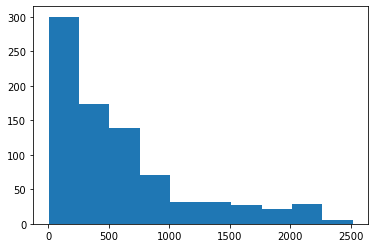

In [591]:
import matplotlib.pyplot as plt
print(df.groupby('pitcherid').size().describe())
print(plt.hist(df.groupby('pitcherid').size()))

Look at distribution of pitches thrown

In [592]:
df.pitch_type.value_counts().index

Index(['FF', 'SL', 'FT', 'CH', 'CB'], dtype='object')

Text(0.5, 0, 'pitch type')

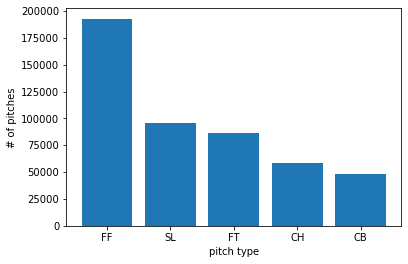

In [593]:
import matplotlib.pyplot as plt
plt.bar(df.pitch_type.value_counts().index, df.pitch_type.value_counts().values)
plt.ylabel("# of pitches")
plt.xlabel("pitch type")

Unbalanced data will need some resampling technique to baalance out pitch types. I will use the SMOTE technique to balance the output data. This is done to prevent the model from just predicting 4-seam fastball every pitch.

## Balance Data (SMOTE)

In [594]:
df.columns

Index(['inning', 'is_bottom', 'balls', 'strikes', 'outs_before', 'is_lhp',
       'is_lhb', 'pitch_type', 'bat_score_before', 'field_score',
       'basecode_before', 'batterid', 'pitcherid', 'cid'],
      dtype='object')

In [595]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
# transform the dataset
# over = SMOTE(sampling_strategy=0.1) # oversample minority class to be 10% majority
# under = RandomUnderSampler(sampling_strategy=0.5) # undersample majority to be 50% more than minority
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)

inputs = df.loc[:,df.columns != 'pitch_type']
output = df.pitch_type

# label encode the target variable
#output = LabelEncoder().fit_transform(output)
# transform the dataset
min_strategy = {"FT":100000, "CB":100000, "SL":100000, "CH":100000}
oversample = SMOTE(sampling_strategy=min_strategy)
maj_strategy = {"FF":100000}
undersample = RandomUnderSampler(maj_strategy)
steps = [('o', oversample), ('u', undersample)]
pipeline = Pipeline(steps=steps)

inputs, output = pipeline.fit_resample(inputs, output)
#inputs, output = oversample.fit_resample(inputs, output)

/Users/TyPainter1/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:587: FutureWarning: Pass sampling_strategy={'FF': 100000} as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Text(0.5, 0, 'pitch type')

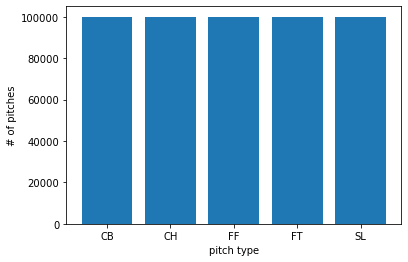

In [596]:
plt.bar(np.unique(output, return_counts=True)[0], np.unique(output, return_counts=True)[1])
plt.ylabel("# of pitches")
plt.xlabel("pitch type")

When I oversampled the minority classes (FT, CB, SL, CH) I made sure that over 50% of the data was still the original data and not the synthesized samples. I did the same for the majority class (FF) when I undersampled.

count     830.000000
mean      602.409639
std       611.469839
min         6.000000
25%       153.000000
50%       409.500000
75%       797.000000
max      3290.000000
dtype: float64
(array([363., 205., 109.,  37.,  40.,  35.,  18.,  17.,   4.,   2.]), array([   6. ,  334.4,  662.8,  991.2, 1319.6, 1648. , 1976.4, 2304.8,
       2633.2, 2961.6, 3290. ]), <BarContainer object of 10 artists>)


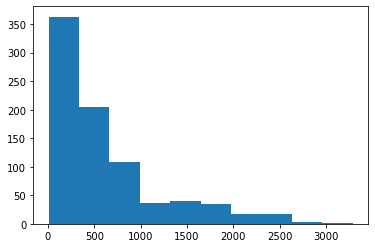

In [597]:
print(inputs.groupby('pitcherid').size().describe())
print(plt.hist(inputs.groupby('pitcherid').size()))

## Feature Engineering

I would like to caclulate some pitcher tendencies based on the count, especially with 2 strikes. To avoid diluting the count data, I will generalize the count variable to ahead, behind, even, and first pitch. I will also create a variable for 2 strikes. Then I will group pitcher id and these variables together to get tendency statistics to pass into the model.

In [598]:
inputs.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
0,5,1,1,1,1,1,1,4,1,4,115,1150,2034
1,1,1,1,2,0,1,1,0,0,0,34,1368,2075
2,12,1,1,2,1,0,1,2,2,0,203,1153,2024
3,6,0,0,2,0,0,1,0,0,0,356,1172,2094
4,8,0,0,1,1,0,1,1,2,5,296,1161,2032


In [599]:
p_count = []
for i in range(len(inputs)):
    if ((inputs.balls[i]==0) & (inputs.strikes[i]==0)):
        p_count.append("first_pitch")
    elif inputs.balls[i] > inputs.strikes[i]:
        p_count.append("behind")
    elif inputs.balls[i] < inputs.strikes[i]:
        p_count.append("ahead")
    elif inputs.balls[i] == inputs.strikes[i]:
        p_count.append("even")

In [600]:
p_2strike = []
for i in range(len(inputs)):
    if (inputs.strikes[i]==2):
        p_2strike.append("yes")
    else: 
        p_2strike.append("no")

In [601]:
# # convert counts to dummy variables
# p_count_dummy = pd.get_dummies(p_count, prefix="p")
# p_count_dummy

In [602]:
# p_2strike_dummy = pd.get_dummies(p_2strike, prefix="p_2strike")
# p_2strike_dummy

In [603]:
inputs['p_count'] = p_count
inputs = inputs.drop(columns={'balls', 'strikes'})
inputs['p_2strike'] = p_2strike
inputs.head()

,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid,p_count,p_2strike
0,5,1,1,1,1,4,1,4,115,1150,2034,even,no
1,1,1,0,1,1,0,0,0,34,1368,2075,ahead,yes
2,12,1,1,0,1,2,2,0,203,1153,2024,ahead,yes
3,6,0,0,0,1,0,0,0,356,1172,2094,ahead,yes
4,8,0,1,0,1,1,2,5,296,1161,2032,ahead,no


Next, I wanted to create more generalized inputs for base runners. The main categories would if there is a runner in scoring position, double play possibility, both RISP and DP, or bases empty.

In [604]:
base_runners = []
dp_list = [1,3,5,7]
for i in range(len(inputs)):
    if ((inputs.basecode_before[i]>=2) & (inputs.basecode_before[i] in dp_list) & (inputs.outs_before[i]<2)):
        base_runners.append("RISP_DP")
    elif (inputs.basecode_before[i]>=2):
        base_runners.append("RISP")
    elif ((inputs.basecode_before[i] in dp_list) & (inputs.outs_before[i]<2)):
        base_runners.append("DP")
    else:
        base_runners.append("Other")

In [605]:
# base_runners_dummy = pd.get_dummies(base_runners, prefix="base_runners")
# base_runners_dummy

In [606]:
inputs['base_runners'] = base_runners
inputs = inputs.drop(columns={'basecode_before'})
inputs.head()

,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,batterid,pitcherid,cid,p_count,p_2strike,base_runners
0,5,1,1,1,1,4,1,115,1150,2034,even,no,RISP
1,1,1,0,1,1,0,0,34,1368,2075,ahead,yes,Other
2,12,1,1,0,1,2,2,203,1153,2024,ahead,yes,Other
3,6,0,0,0,1,0,0,356,1172,2094,ahead,yes,Other
4,8,0,1,0,1,1,2,296,1161,2032,ahead,no,RISP_DP


After creating these feature I will group the new columns with pitcher ID and calculate pitcher tendencies based on these feature situations

In [607]:
df2 = inputs
df2['pitch_type'] = output
df2.head()

,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,batterid,pitcherid,cid,p_count,p_2strike,base_runners,pitch_type
0,5,1,1,1,1,4,1,115,1150,2034,even,no,RISP,CB
1,1,1,0,1,1,0,0,34,1368,2075,ahead,yes,Other,CB
2,12,1,1,0,1,2,2,203,1153,2024,ahead,yes,Other,CB
3,6,0,0,0,1,0,0,356,1172,2094,ahead,yes,Other,CB
4,8,0,1,0,1,1,2,296,1161,2032,ahead,no,RISP_DP,CB


In [608]:
df2["situation_count"] = df2.groupby(['pitcherid', 'p_count', 'p_2strike', 'base_runners'])['pitch_type'].transform(lambda x: x.count())
df2.head()

,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,batterid,pitcherid,cid,p_count,p_2strike,base_runners,pitch_type,situation_count
0,5,1,1,1,1,4,1,115,1150,2034,even,no,RISP,CB,37
1,1,1,0,1,1,0,0,34,1368,2075,ahead,yes,Other,CB,85
2,12,1,1,0,1,2,2,203,1153,2024,ahead,yes,Other,CB,106
3,6,0,0,0,1,0,0,356,1172,2094,ahead,yes,Other,CB,249
4,8,0,1,0,1,1,2,296,1161,2032,ahead,no,RISP_DP,CB,6


In [609]:
df2["pitch_type_count"] = df2.groupby(['pitcherid', 'p_count', 'p_2strike', 'base_runners','pitch_type'])['cid'].transform(lambda x: x.count())
df2.head()

,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,batterid,pitcherid,cid,p_count,p_2strike,base_runners,pitch_type,situation_count,pitch_type_count
0,5,1,1,1,1,4,1,115,1150,2034,even,no,RISP,CB,37,12
1,1,1,0,1,1,0,0,34,1368,2075,ahead,yes,Other,CB,85,30
2,12,1,1,0,1,2,2,203,1153,2024,ahead,yes,Other,CB,106,28
3,6,0,0,0,1,0,0,356,1172,2094,ahead,yes,Other,CB,249,160
4,8,0,1,0,1,1,2,296,1161,2032,ahead,no,RISP_DP,CB,6,2


In [610]:
df2["sit_pitch_prob"] = df2.pitch_type_count/df2.situation_count
df2.head()

,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,batterid,pitcherid,cid,p_count,p_2strike,base_runners,pitch_type,situation_count,pitch_type_count,sit_pitch_prob
0,5,1,1,1,1,4,1,115,1150,2034,even,no,RISP,CB,37,12,0.324324
1,1,1,0,1,1,0,0,34,1368,2075,ahead,yes,Other,CB,85,30,0.352941
2,12,1,1,0,1,2,2,203,1153,2024,ahead,yes,Other,CB,106,28,0.264151
3,6,0,0,0,1,0,0,356,1172,2094,ahead,yes,Other,CB,249,160,0.642570
4,8,0,1,0,1,1,2,296,1161,2032,ahead,no,RISP_DP,CB,6,2,0.333333


In [611]:
pitch_tend_df = df2.groupby(['pitcherid', 'p_count', 'p_2strike', 'base_runners','pitch_type'])['sit_pitch_prob'].mean().reset_index()
pitch_tend_df

,pitcherid,p_count,p_2strike,base_runners,pitch_type,sit_pitch_prob
0,1000,ahead,no,DP,FF,0.100000
1,1000,ahead,no,DP,FT,0.900000
2,1000,ahead,no,Other,FF,0.119048
3,1000,ahead,no,Other,FT,0.500000
4,1000,ahead,no,Other,SL,0.380952
...,...,...,...,...,...,...
57454,1828,first_pitch,no,RISP_DP,SL,0.400000
57455,1829,behind,no,Other,SL,1.000000
57456,1829,even,yes,Other,SL,1.000000
57457,1829,first_pitch,no,Other,SL,1.000000


In [612]:
pt_df = pitch_tend_df
pt_df = pt_df.pivot_table('sit_pitch_prob', ['pitcherid', 'p_count', 'p_2strike', 'base_runners'],'pitch_type').reset_index()
pt_df

pitch_type,pitcherid,p_count,p_2strike,base_runners,CB,CH,FF,FT,SL
0,1000,ahead,no,DP,NaN,NaN,0.100000,0.900000,NaN
1,1000,ahead,no,Other,NaN,NaN,0.119048,0.500000,0.380952
2,1000,ahead,no,RISP,NaN,NaN,0.153846,0.538462,0.307692
3,1000,ahead,no,RISP_DP,NaN,NaN,NaN,0.833333,0.166667
4,1000,ahead,yes,DP,NaN,NaN,0.142857,0.571429,0.285714
...,...,...,...,...,...,...,...,...,...
19996,1828,first_pitch,no,RISP_DP,0.4,NaN,0.200000,NaN,0.400000
19997,1829,behind,no,Other,NaN,NaN,NaN,NaN,1.000000
19998,1829,even,yes,Other,NaN,NaN,NaN,NaN,1.000000
19999,1829,first_pitch,no,Other,NaN,NaN,NaN,NaN,1.000000


In [613]:
pt_df['CB'] = pt_df['CB'].fillna(0)
pt_df['CH'] = pt_df['CH'].fillna(0)
pt_df['FF'] = pt_df['FF'].fillna(0)
pt_df['FT'] = pt_df['FT'].fillna(0)
pt_df['SL'] = pt_df['SL'].fillna(0)
pt_df.head()

pitch_type,pitcherid,p_count,p_2strike,base_runners,CB,CH,FF,FT,SL
0,1000,ahead,no,DP,0.0,0.0,0.100000,0.900000,0.000000
1,1000,ahead,no,Other,0.0,0.0,0.119048,0.500000,0.380952
2,1000,ahead,no,RISP,0.0,0.0,0.153846,0.538462,0.307692
3,1000,ahead,no,RISP_DP,0.0,0.0,0.000000,0.833333,0.166667
4,1000,ahead,yes,DP,0.0,0.0,0.142857,0.571429,0.285714


In [614]:
inputs = inputs.merge(pt_df, how='left', on=['pitcherid', 'p_count', 'p_2strike', 'base_runners']).reset_index(drop=True)
inputs = inputs.drop(columns={'pitch_type', 'situation_count', 'pitch_type_count', 'sit_pitch_prob'})
inputs

,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,batterid,pitcherid,cid,p_count,p_2strike,base_runners,CB,CH,FF,FT,SL
0,5,1,1,1,1,4,1,115,1150,2034,even,no,RISP,0.324324,0.378378,0.135135,0.162162,0.000000
1,1,1,0,1,1,0,0,34,1368,2075,ahead,yes,Other,0.352941,0.376471,0.235294,0.023529,0.011765
2,12,1,1,0,1,2,2,203,1153,2024,ahead,yes,Other,0.264151,0.028302,0.009434,0.301887,0.396226
3,6,0,0,0,1,0,0,356,1172,2094,ahead,yes,Other,0.642570,0.104418,0.136546,0.108434,0.008032
4,8,0,1,0,1,1,2,296,1161,2032,ahead,no,RISP_DP,0.333333,0.000000,0.166667,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,7,1,1,0,1,5,2,196,1003,2001,first_pitch,no,RISP,0.000000,0.025641,0.051282,0.333333,0.589744
499996,3,1,1,1,0,1,1,245,1540,2041,first_pitch,no,Other,0.075949,0.367089,0.367089,0.037975,0.151899
499997,5,0,1,0,0,4,1,32,1578,2041,ahead,no,DP,0.000000,0.000000,0.000000,0.000000,1.000000
499998,3,1,1,0,1,2,2,538,1696,2039,ahead,no,Other,0.524272,0.048544,0.097087,0.213592,0.116505


The final dataframe now has the pitcher tendencies based on the count and base runner situations. The new columns created must be converted into dummy variables

In [615]:
inputs.columns

Index(['inning', 'is_bottom', 'outs_before', 'is_lhp', 'is_lhb',
       'bat_score_before', 'field_score', 'batterid', 'pitcherid', 'cid',
       'p_count', 'p_2strike', 'base_runners', 'CB', 'CH', 'FF', 'FT', 'SL'],
      dtype='object')

In [616]:
p_2strike_dummy = pd.get_dummies(inputs.p_2strike, prefix="p_2strike")
p_2strike_dummy.head()

,p_2strike_no,p_2strike_yes
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0


In [617]:
inputs.columns

Index(['inning', 'is_bottom', 'outs_before', 'is_lhp', 'is_lhb',
       'bat_score_before', 'field_score', 'batterid', 'pitcherid', 'cid',
       'p_count', 'p_2strike', 'base_runners', 'CB', 'CH', 'FF', 'FT', 'SL'],
      dtype='object')

In [618]:
inputs = inputs.merge(p_2strike_dummy, how='left', on=inputs.index)
inputs = inputs.drop(columns={"key_0", 'p_2strike'})

p_count_dummy = pd.get_dummies(inputs.p_count, prefix="p_count")
inputs = inputs.merge(p_count_dummy, how='left', on=inputs.index)
inputs = inputs.drop(columns={"key_0", 'p_count'})

base_runners_dummy = pd.get_dummies(inputs.base_runners, prefix="runners")
inputs = inputs.merge(base_runners_dummy, how='left', on=inputs.index)
inputs = inputs.drop(columns={"key_0",'base_runners'})

In [619]:
inputs.head()

,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,batterid,pitcherid,cid,...,p_2strike_no,p_2strike_yes,p_count_ahead,p_count_behind,p_count_even,p_count_first_pitch,runners_DP,runners_Other,runners_RISP,runners_RISP_DP
0,5,1,1,1,1,4,1,115,1150,2034,...,1,0,0,0,1,0,0,0,1,0
1,1,1,0,1,1,0,0,34,1368,2075,...,0,1,1,0,0,0,0,1,0,0
2,12,1,1,0,1,2,2,203,1153,2024,...,0,1,1,0,0,0,0,1,0,0
3,6,0,0,0,1,0,0,356,1172,2094,...,0,1,1,0,0,0,0,1,0,0
4,8,0,1,0,1,1,2,296,1161,2032,...,1,0,1,0,0,0,0,0,0,1


# Data Splitting

In [620]:
inputs = pd.DataFrame(inputs)
inputs.head()

,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,batterid,pitcherid,cid,...,p_2strike_no,p_2strike_yes,p_count_ahead,p_count_behind,p_count_even,p_count_first_pitch,runners_DP,runners_Other,runners_RISP,runners_RISP_DP
0,5,1,1,1,1,4,1,115,1150,2034,...,1,0,0,0,1,0,0,0,1,0
1,1,1,0,1,1,0,0,34,1368,2075,...,0,1,1,0,0,0,0,1,0,0
2,12,1,1,0,1,2,2,203,1153,2024,...,0,1,1,0,0,0,0,1,0,0
3,6,0,0,0,1,0,0,356,1172,2094,...,0,1,1,0,0,0,0,1,0,0
4,8,0,1,0,1,1,2,296,1161,2032,...,1,0,1,0,0,0,0,0,0,1


In [621]:
inputs.columns

Index(['inning', 'is_bottom', 'outs_before', 'is_lhp', 'is_lhb',
       'bat_score_before', 'field_score', 'batterid', 'pitcherid', 'cid', 'CB',
       'CH', 'FF', 'FT', 'SL', 'p_2strike_no', 'p_2strike_yes',
       'p_count_ahead', 'p_count_behind', 'p_count_even',
       'p_count_first_pitch', 'runners_DP', 'runners_Other', 'runners_RISP',
       'runners_RISP_DP'],
      dtype='object')

In [622]:
# convert numerical variables to categorical 
cat_cols = ['inning', 'is_bottom', 'outs_before', 'is_lhp', 'is_lhb', 'batterid', 'pitcherid', 'cid']
inputs[cat_cols] = inputs[cat_cols].astype('category')
#pd.Categorical(inputs[cat_cols])
print(inputs.dtypes)
inputs

inning                 category
is_bottom              category
outs_before            category
is_lhp                 category
is_lhb                 category
bat_score_before          int64
field_score               int64
batterid               category
pitcherid              category
cid                    category
CB                      float64
CH                      float64
FF                      float64
FT                      float64
SL                      float64
p_2strike_no              uint8
p_2strike_yes             uint8
p_count_ahead             uint8
p_count_behind            uint8
p_count_even              uint8
p_count_first_pitch       uint8
runners_DP                uint8
runners_Other             uint8
runners_RISP              uint8
runners_RISP_DP           uint8
dtype: object


,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,batterid,pitcherid,cid,...,p_2strike_no,p_2strike_yes,p_count_ahead,p_count_behind,p_count_even,p_count_first_pitch,runners_DP,runners_Other,runners_RISP,runners_RISP_DP
0,5,1,1,1,1,4,1,115,1150,2034,...,1,0,0,0,1,0,0,0,1,0
1,1,1,0,1,1,0,0,34,1368,2075,...,0,1,1,0,0,0,0,1,0,0
2,12,1,1,0,1,2,2,203,1153,2024,...,0,1,1,0,0,0,0,1,0,0
3,6,0,0,0,1,0,0,356,1172,2094,...,0,1,1,0,0,0,0,1,0,0
4,8,0,1,0,1,1,2,296,1161,2032,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,7,1,1,0,1,5,2,196,1003,2001,...,1,0,0,0,0,1,0,0,1,0
499996,3,1,1,1,0,1,1,245,1540,2041,...,1,0,0,0,0,1,0,1,0,0
499997,5,0,1,0,0,4,1,32,1578,2041,...,1,0,1,0,0,0,1,0,0,0
499998,3,1,1,0,1,2,2,538,1696,2039,...,1,0,1,0,0,0,0,1,0,0


In [623]:
inputs.columns

Index(['inning', 'is_bottom', 'outs_before', 'is_lhp', 'is_lhb',
       'bat_score_before', 'field_score', 'batterid', 'pitcherid', 'cid', 'CB',
       'CH', 'FF', 'FT', 'SL', 'p_2strike_no', 'p_2strike_yes',
       'p_count_ahead', 'p_count_behind', 'p_count_even',
       'p_count_first_pitch', 'runners_DP', 'runners_Other', 'runners_RISP',
       'runners_RISP_DP'],
      dtype='object')

In [624]:
from sklearn import preprocessing
num_cols = ['bat_score_before', 'field_score']
inputs[num_cols] = pd.DataFrame(preprocessing.normalize(inputs[num_cols]))
#inputs_norm.columns = inputs.columns
inputs.head()

,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,batterid,pitcherid,cid,...,p_2strike_no,p_2strike_yes,p_count_ahead,p_count_behind,p_count_even,p_count_first_pitch,runners_DP,runners_Other,runners_RISP,runners_RISP_DP
0,5,1,1,1,1,0.970143,0.242536,115,1150,2034,...,1,0,0,0,1,0,0,0,1,0
1,1,1,0,1,1,0.000000,0.000000,34,1368,2075,...,0,1,1,0,0,0,0,1,0,0
2,12,1,1,0,1,0.707107,0.707107,203,1153,2024,...,0,1,1,0,0,0,0,1,0,0
3,6,0,0,0,1,0.000000,0.000000,356,1172,2094,...,0,1,1,0,0,0,0,1,0,0
4,8,0,1,0,1,0.447214,0.894427,296,1161,2032,...,1,0,1,0,0,0,0,0,0,1


Convert output to dummy variable to match predicted pitch probabilities

In [625]:
output = pd.get_dummies(output, prefix="true")
output

,true_CB,true_CH,true_FF,true_FT,true_SL
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
499995,0,0,0,0,1
499996,0,0,0,0,1
499997,0,0,0,0,1
499998,0,0,0,0,1


Split data into train and validation data

In [626]:
from sklearn.model_selection import train_test_split

# split train and validation
x_train, x_val, y_train, y_val = train_test_split(inputs, output, test_size=0.2, shuffle = True, random_state= 3) 

# check shapes
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_val shape: {}".format(x_val.shape))
print("y val shape: {}".format(y_val.shape))

x_train shape: (400000, 25)
y_train shape: (400000, 5)
x_val shape: (100000, 25)
y val shape: (100000, 5)


# Modeling

## XGBoost
From a previous project I worked on similar to pitch predition, I also used XGBoost and it worked out well.
<br>
- The first model I decided to use was XGBoost Regression. XGBoost is boosting algorithm that learns off of itself, generating an ensemble of tree models to optimize the loss function. 
- The [scikit-learn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html) Gradient Boosting regression documentation was used to develop the model.

### Train Model

In [627]:
x_train.columns

Index(['inning', 'is_bottom', 'outs_before', 'is_lhp', 'is_lhb',
       'bat_score_before', 'field_score', 'batterid', 'pitcherid', 'cid', 'CB',
       'CH', 'FF', 'FT', 'SL', 'p_2strike_no', 'p_2strike_yes',
       'p_count_ahead', 'p_count_behind', 'p_count_even',
       'p_count_first_pitch', 'runners_DP', 'runners_Other', 'runners_RISP',
       'runners_RISP_DP'],
      dtype='object')

In [628]:
y = ['FF', 'FT', 'FF', 'CU']
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
y.shape

(4, 4)

In [662]:
y_train.shape

(400000, 5)

In [663]:
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

# establish parameters
params = {
    "n_estimators": 50,
    "max_depth": 3,
    "min_samples_split": 2,
    "learning_rate": 0.01,
}

######## time model ############
import time
start_time = time.time()
################################

# fit model
#reg = MultiOutputClassifier(ensemble.GradientBoostingClassifier(**params)).fit(x_train[0:10], y_train[0:10])
reg = OneVsRestClassifier(ensemble.GradientBoostingClassifier(**params)).fit(x_train, y_train)
trained_model = reg
preds = reg.predict_proba(x_val)
######### print timed model ###########
print("--- %s seconds (fitting) ---" % (time.time() - start_time))

# evaluate model
ce = log_loss(y_val, preds)
print("Validation Cross-entropy loss: {:.5f}".format(ce))

--- 338.58043098449707 seconds (fitting) ---
Validation Cross-entropy loss: 1.32194


In [664]:
from sklearn.metrics import roc_auc_score
print('AUC: ', roc_auc_score(y_val,preds,multi_class='ovr'))

AUC:  0.8361755447696462


In [665]:
preds[:, 0]

array([0.13313802, 0.20680126, 0.12397682, ..., 0.30400952, 0.12397682,
       0.12397682])

In [666]:
x,_,_ = roc_curve(y_bin[:,0], preds[:, 0])

In [667]:
x[1]

0.0009741111235997153

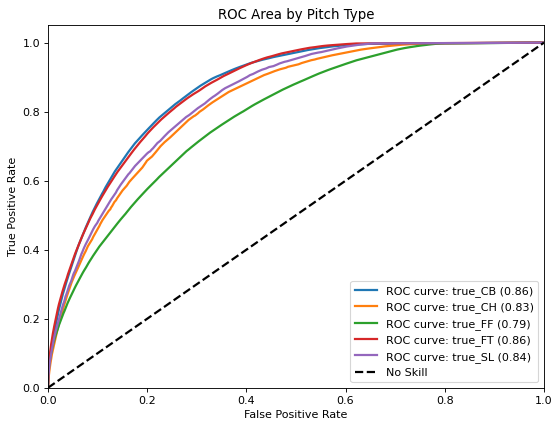

In [668]:
### ROC CURVE ###
# Binarize the output
#y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_bin=np.array(y_val)
n_classes = y_bin.shape[1]

from scipy import interp
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from itertools import cycle
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:,i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
lw = 2

# Plot all ROC curves
figure(figsize=(8, 6), dpi=80)

#pitch_class = ["breaking ball", "changeup", "fastball", "other"]
pitch_class = y_val.columns
#colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink"])
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        #color=color,
        lw=lw,
        label="ROC curve: {0} ({1:0.2f})".format(pitch_class[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw, label="No Skill")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Area by Pitch Type")
plt.legend(loc="lower right")
plt.show()

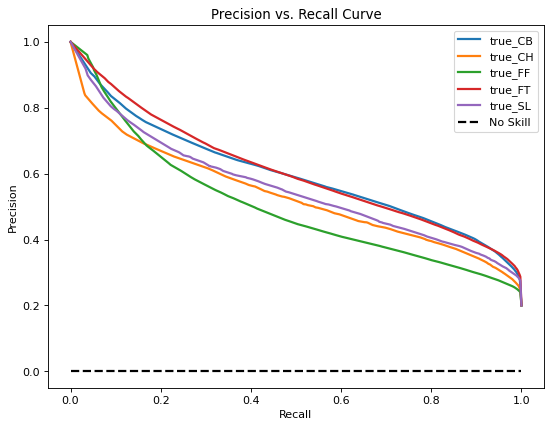

In [669]:
from sklearn.metrics import precision_recall_curve
### PRECISION-RECALL CURVE ###
figure(figsize=(8, 6), dpi=80)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i],
                                                        preds[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=pitch_class[i])

no_skill = len(preds[preds==1]) / len(preds)
plt.plot([0, 1], [no_skill, no_skill], "k--", lw=lw, label='No Skill')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall Curve")
plt.show()

In [670]:
#reg.estimators_[].feature_importances_

feat_impts = [] 
for reg in reg.estimators_:
    feat_impts.append(reg.feature_importances_)

np.mean(feat_impts, axis=0)

array([0.        , 0.        , 0.        , 0.        , 0.00721845,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.2       , 0.19614645, 0.2       , 0.2       , 0.1966351 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

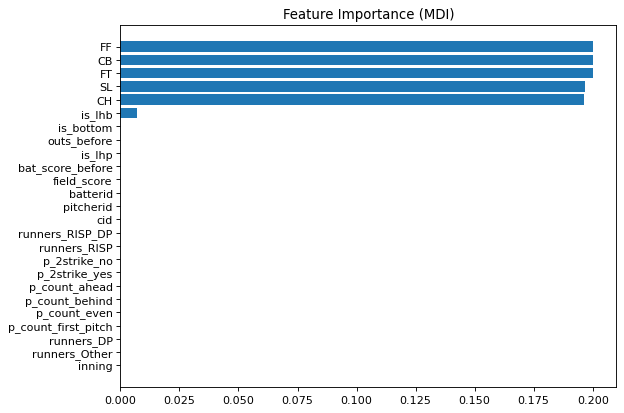

In [671]:
#feature_importance = reg.feature_importances_
feature_importance = np.mean(feat_impts, axis=0)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
figure(figsize=(8, 6), dpi=80)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(inputs.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.show()

# Test Model

I have to read in the test data and add all the features I created.

In [672]:
df = pd.read_csv("Q2_pitches_test.csv")
inputs = df.loc[:,df.columns]

In [673]:
df.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid,FF,FT,CB,SL,CH
0,9,1,0,0,0,0,1,2,4,0,1,1000,2000,NaN,NaN,NaN,NaN,NaN
1,9,0,0,0,2,0,0,4,2,0,2,1001,2001,NaN,NaN,NaN,NaN,NaN
2,9,0,1,1,1,0,0,4,2,0,3,1001,2001,NaN,NaN,NaN,NaN,NaN
3,9,0,0,2,0,0,0,4,2,0,4,1001,2001,NaN,NaN,NaN,NaN,NaN
4,9,0,1,2,0,0,0,4,2,0,4,1001,2001,NaN,NaN,NaN,NaN,NaN


In [674]:
p_count = []
for i in range(len(inputs)):
    if ((inputs.balls[i]==0) & (inputs.strikes[i]==0)):
        p_count.append("first_pitch")
    elif inputs.balls[i] > inputs.strikes[i]:
        p_count.append("behind")
    elif inputs.balls[i] < inputs.strikes[i]:
        p_count.append("ahead")
    elif inputs.balls[i] == inputs.strikes[i]:
        p_count.append("even")
    
p_2strike = []
for i in range(len(inputs)):
    if (inputs.strikes[i]==2):
        p_2strike.append("yes")
    else: 
        p_2strike.append("no")
        
inputs['p_count'] = p_count
inputs = inputs.drop(columns={'balls', 'strikes'})
inputs['p_2strike'] = p_2strike

base_runners = []
dp_list = [1,3,5,7]
for i in range(len(inputs)):
    if ((inputs.basecode_before[i]>=2) & (inputs.basecode_before[i] in dp_list) & (inputs.outs_before[i]<2)):
        base_runners.append("RISP_DP")
    elif (inputs.basecode_before[i]>=2):
        base_runners.append("RISP")
    elif ((inputs.basecode_before[i] in dp_list) & (inputs.outs_before[i]<2)):
        base_runners.append("DP")
    else:
        base_runners.append("Other")
        
inputs['base_runners'] = base_runners
inputs = inputs.drop(columns={'basecode_before'})

# df2 = inputs
# df2['pitch_type'] = output

# df2["situation_count"] = df2.groupby(['pitcherid', 'p_count', 'p_2strike', 'base_runners'])['pitch_type'].transform(lambda x: x.count())

# df2["pitch_type_count"] = df2.groupby(['pitcherid', 'p_count', 'p_2strike', 'base_runners','pitch_type'])['cid'].transform(lambda x: x.count())

# df2["sit_pitch_prob"] = df2.pitch_type_count/df2.situation_count

# pitch_tend_df = df2.groupby(['pitcherid', 'p_count', 'p_2strike', 'base_runners','pitch_type'])['sit_pitch_prob'].mean().reset_index()

# pt_df = pitch_tend_df
# pt_df = pt_df.pivot_table('sit_pitch_prob', ['pitcherid', 'p_count', 'p_2strike', 'base_runners'],'pitch_type').reset_index()

# pt_df['CB'] = pt_df['CB'].fillna(0)
# pt_df['CH'] = pt_df['CH'].fillna(0)
# pt_df['FF'] = pt_df['FF'].fillna(0)
# pt_df['FT'] = pt_df['FT'].fillna(0)
# pt_df['SL'] = pt_df['SL'].fillna(0)

In [675]:
inputs = inputs.drop(columns={'FF','FT', 'CB', 'SL', 'CH'})

In [676]:
inputs = inputs.merge(pt_df, how='left', on=['pitcherid', 'p_count', 'p_2strike', 'base_runners']).reset_index(drop=True)
#inputs = inputs.drop(columns={'pitch_type', 'situation_count', 'pitch_type_count', 'sit_pitch_prob'})

p_2strike_dummy = pd.get_dummies(inputs.p_2strike, prefix="p_2strike")
inputs = inputs.merge(p_2strike_dummy, how='left', on=inputs.index)
inputs = inputs.drop(columns={"key_0", 'p_2strike'})

p_count_dummy = pd.get_dummies(inputs.p_count, prefix="p_count")
inputs = inputs.merge(p_count_dummy, how='left', on=inputs.index)
inputs = inputs.drop(columns={"key_0", 'p_count'})

base_runners_dummy = pd.get_dummies(inputs.base_runners, prefix="runners")
inputs = inputs.merge(base_runners_dummy, how='left', on=inputs.index)
inputs = inputs.drop(columns={"key_0",'base_runners'})

Replace NaN values for new pitchers in the test data with the average values

In [677]:
inputs = inputs.fillna(inputs.mean())

## Get Test Probabilities

In [678]:
cat_cols = ['inning', 'is_bottom', 'outs_before', 'is_lhp', 'is_lhb', 'batterid', 'pitcherid', 'cid']
inputs[cat_cols] = inputs[cat_cols].astype('category')
num_cols = ['bat_score_before', 'field_score']
inputs[num_cols] = pd.DataFrame(preprocessing.normalize(inputs[num_cols]))

In [679]:
test_inputs=inputs
test_inputs.columns

Index(['inning', 'is_bottom', 'outs_before', 'is_lhp', 'is_lhb',
       'bat_score_before', 'field_score', 'batterid', 'pitcherid', 'cid', 'CB',
       'CH', 'FF', 'FT', 'SL', 'p_2strike_no', 'p_2strike_yes',
       'p_count_ahead', 'p_count_behind', 'p_count_even',
       'p_count_first_pitch', 'runners_DP', 'runners_Other', 'runners_RISP',
       'runners_RISP_DP'],
      dtype='object')

In [680]:
test_inputs

,inning,is_bottom,outs_before,is_lhp,is_lhb,bat_score_before,field_score,batterid,pitcherid,cid,...,p_2strike_no,p_2strike_yes,p_count_ahead,p_count_behind,p_count_even,p_count_first_pitch,runners_DP,runners_Other,runners_RISP,runners_RISP_DP
0,9,1,0,0,1,0.447214,0.894427,1,1000,2000,...,1,0,0,0,0,1,0,1,0,0
1,9,0,2,0,0,0.894427,0.447214,2,1001,2001,...,1,0,0,0,0,1,0,1,0,0
2,9,0,1,0,0,0.894427,0.447214,3,1001,2001,...,1,0,0,0,1,0,0,1,0,0
3,9,0,0,0,0,0.894427,0.447214,4,1001,2001,...,0,1,1,0,0,0,0,1,0,0
4,9,0,0,0,0,0.894427,0.447214,4,1001,2001,...,0,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160301,1,0,0,0,1,0.000000,0.000000,367,1506,2060,...,1,0,1,0,0,0,1,0,0,0
160302,1,0,0,0,0,0.000000,0.000000,157,1506,2060,...,1,0,1,0,0,0,0,0,0,1
160303,1,0,0,0,1,0.000000,0.000000,159,1506,2060,...,0,1,0,1,0,0,0,1,0,0
160304,1,0,0,0,1,0.000000,0.000000,159,1506,2060,...,0,1,0,1,0,0,0,1,0,0


In [681]:
test_preds = trained_model.predict_proba(test_inputs)

In [682]:
test_preds

array([[0.12397682, 0.12426529, 0.18340497, 0.4172478 , 0.15576002],
       [0.12397682, 0.31189011, 0.18340497, 0.14834809, 0.26629494],
       [0.12397682, 0.31189011, 0.23159138, 0.14210755, 0.21014231],
       ...,
       [0.29100383, 0.1779336 , 0.26368389, 0.14277978, 0.1323037 ],
       [0.29100383, 0.1779336 , 0.26368389, 0.14277978, 0.1323037 ],
       [0.29100383, 0.1779336 , 0.26368389, 0.14277978, 0.1323037 ]])

In [684]:
print(y_train.columns)
print(y_val.columns)

Index(['true_CB', 'true_CH', 'true_FF', 'true_FT', 'true_SL'], dtype='object')
Index(['true_CB', 'true_CH', 'true_FF', 'true_FT', 'true_SL'], dtype='object')


In [686]:
df = pd.read_csv("Q2_pitches_test.csv")
df.CB=test_preds[:,0]
df.CH=test_preds[:,1]
df.FF=test_preds[:,2]
df.FT=test_preds[:,3]
df.SL=test_preds[:,4]
df.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid,FF,FT,CB,SL,CH
0,9,1,0,0,0,0,1,2,4,0,1,1000,2000,0.183405,0.417248,0.123977,0.155760,0.124265
1,9,0,0,0,2,0,0,4,2,0,2,1001,2001,0.183405,0.148348,0.123977,0.266295,0.311890
2,9,0,1,1,1,0,0,4,2,0,3,1001,2001,0.231591,0.142108,0.123977,0.210142,0.311890
3,9,0,0,2,0,0,0,4,2,0,4,1001,2001,0.277344,0.148348,0.123977,0.210142,0.240789
4,9,0,1,2,0,0,0,4,2,0,4,1001,2001,0.277344,0.148348,0.123977,0.210142,0.240789


In [687]:
df.to_csv("Q2_pitches_test-COMPLETED.CSV")